# Method 1: LDA

First, we check how many class of Y(health_index) is optimal, we use Kmeans and Silhouette score

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

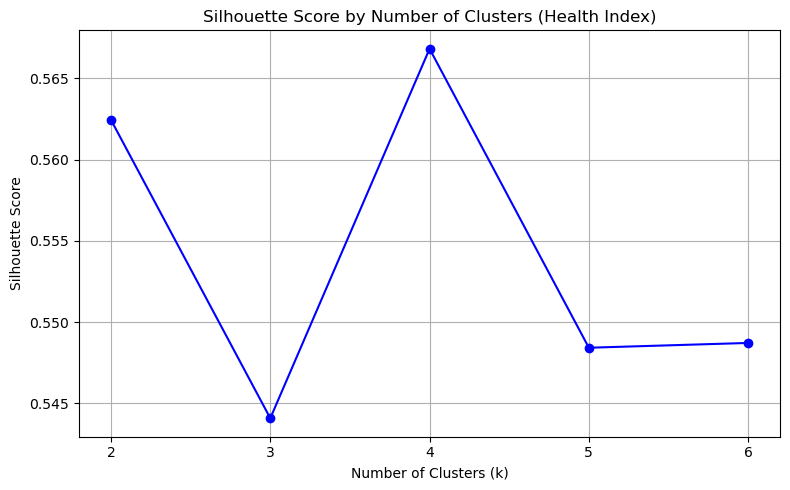

the best k: 4


In [83]:
# Re-import necessary libraries after environment reset
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reload the cleaned 2011 dataset
df = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\2011_cleaned.csv")
# Only retain the data at the District level
df = df[df["County"].notnull() & df["District"].notnull()].copy()

# Step 2: Only retain the data at the District level
X_health = df[["health_index"]].values
silhouette_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_health)
    score = silhouette_score(X_health, labels)
    silhouette_scores[k] = score

# Find best k
best_k = max(silhouette_scores, key=silhouette_scores.get)

# Plot silhouette score as a line plot to visualize clustering quality by k
import matplotlib.pyplot as plt

# Prepare data
k_values = list(silhouette_scores.keys())
scores = list(silhouette_scores.values())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o', linestyle='-', color='blue')
plt.title("Silhouette Score by Number of Clusters (Health Index)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\Silhouette_Score_by_Number_of_Clusters.png')
plt.show()

print(f"the best k: {best_k}")

Check the distribution of 4 class

In [86]:
# Apply KMeans with k=4 to health_index
from sklearn.cluster import KMeans

# Fit model
kmeans4 = KMeans(n_clusters=4, n_init=10, random_state=42)
df["health_level_kmeans4_raw"] = kmeans4.fit_predict(df[["health_index"]])

# Order clusters by centroid to assign interpretable labels
centroids = kmeans4.cluster_centers_.flatten()
ordered = sorted(range(len(centroids)), key=lambda x: centroids[x])
label_map = {old: f"Cluster {i+1}" for i, old in enumerate(ordered)}
df["health_level_kmeans4"] = df["health_level_kmeans4_raw"].map(label_map)

# Count distribution
kmeans4_dist = df["health_level_kmeans4"].value_counts().sort_index()

dataframe_kmeans4 = kmeans4_dist.reset_index().rename(columns={"index": "Cluster", "health_level_kmeans4": "Count"})
dataframe_kmeans4

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Count,count
0,Cluster 1,56
1,Cluster 2,125
2,Cluster 3,124
3,Cluster 4,79


In [88]:
# Prepare LDA using KMeans-based 4-class labels
y_kmeans = df["health_level_kmeans4"]

# Screen housing characteristics as X
final_features = [
    "pct_detached", "pct_semi", "pct_terraced",
    "pct_flat_built", "pct_flat_converted", "pct_flat_commercial", "pct_mobile_home",
    "pct_heated", "pct_overcrowded_rooms", "pct_overcrowded_beds",
    "avg_rooms", "avg_bedrooms", "avg_household_size"
]
X_kmeans = df[final_features]

# Standardize
scaler = StandardScaler()
X_kmeans_scaled = scaler.fit_transform(X_kmeans)

# Fit LDA
lda_kmeans = LDA(n_components=2)
X_lda_kmeans = lda_kmeans.fit_transform(X_kmeans_scaled, y_kmeans)

# Create projection dataframe
df_lda_kmeans = pd.DataFrame(X_lda_kmeans, columns=["LD1", "LD2"])
df_lda_kmeans["health_level_kmeans4"] = y_kmeans
df_lda_kmeans["Area code"] = df["Area code"]

# Feature loadings
lda_kmeans_loadings = pd.DataFrame(lda_kmeans.coef_.T, index=final_features, columns=lda_kmeans.classes_)

# Save results
df_lda_kmeans.to_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\lda_projection_housing_only.csv", index=False)
lda_kmeans_loadings.to_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\lda_feature_contributions.csv")

# Display results
df_lda_kmeans
lda_kmeans_loadings

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
pct_detached,-11.661423,-12.922420,18.554652,-0.410566
pct_semi,-7.673817,-8.925606,12.125870,0.529451
pct_terraced,-8.654974,-9.550832,12.790189,1.171508
pct_flat_built,-12.983257,-12.199143,15.909881,3.533291
pct_flat_converted,-4.663467,-5.227826,6.670929,1.106799
pct_flat_commercial,0.461481,-0.460703,0.413640,-0.247424
pct_mobile_home,-0.350368,-0.537725,0.736231,-0.056410
pct_heated,0.456585,-0.174758,-0.110032,0.125569
pct_overcrowded_rooms,-9.598825,-4.739556,3.697288,8.500190
pct_overcrowded_beds,7.426720,3.405004,-2.227986,-7.155083


In [90]:
df_lda_kmeans

,LD1,LD2,health_level_kmeans4,Area code
0,-3.821205,-0.052057,NaN,NaN
1,-0.236400,0.097341,NaN,NaN
2,-1.979049,-1.880809,NaN,NaN
3,-3.641961,-1.648094,NaN,NaN
4,-2.542957,-1.734095,NaN,NaN
...,...,...,...,...
379,-1.060882,-1.029331,Cluster 2,W06000023
380,-2.817422,-0.971288,Cluster 2,W06000008
381,-1.312707,-0.491353,Cluster 2,W06000009
382,1.167410,0.206047,Cluster 1,W06000010


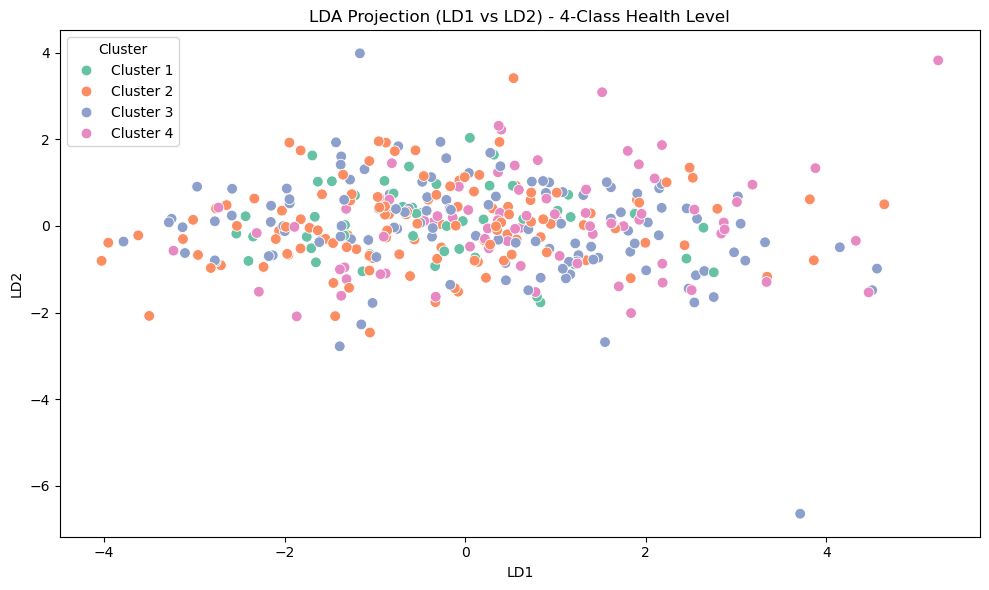

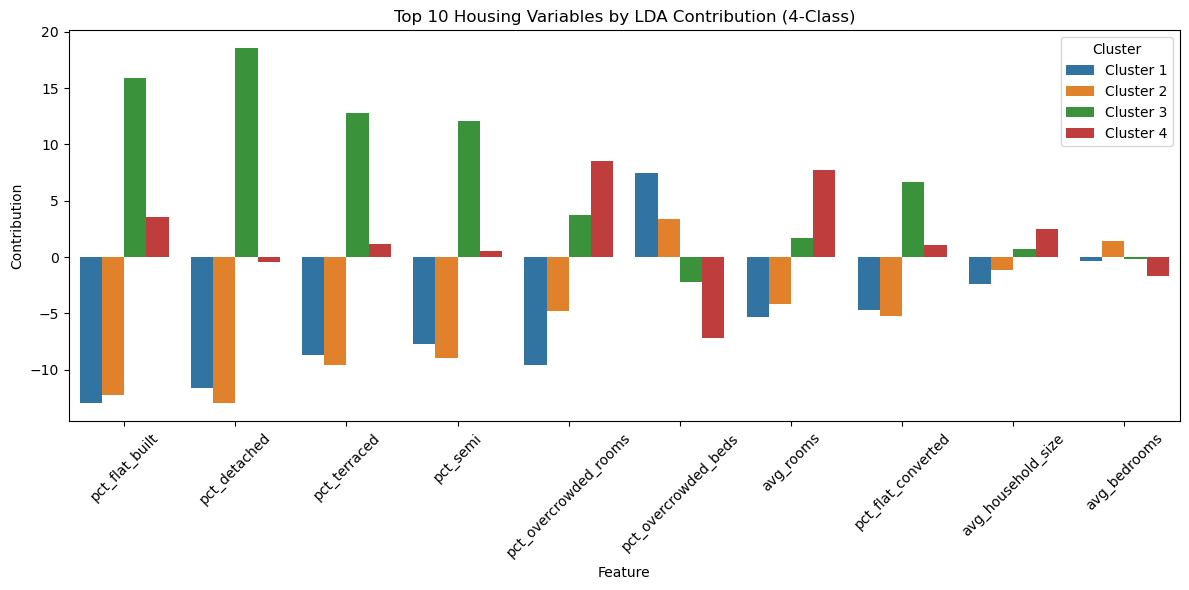

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load uploaded LDA result files (2D projection, 4-class target)
df_lda_2d_proj = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\lda_projection_housing_only.csv")
df_lda_2d_loadings = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\lda_feature_contributions.csv", index_col=0)

# First, LD1 vs LD2 scatter plot by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_lda_2d_proj, x="LD1", y="LD2", hue="health_level_kmeans4", palette="Set2", s=60)
plt.title("LDA Projection (LD1 vs LD2) - 4-Class Health Level")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\LDA_Projection_LD1_vs_LD2.png')
plt.show()

# Second, barplot of top 10 contributing variables across clusters
loadings_abs_2d = df_lda_2d_loadings.abs()
top_features_2d = loadings_abs_2d.sum(axis=1).sort_values(ascending=False).head(10).index.tolist()

df_melt_2d = df_lda_2d_loadings.loc[top_features_2d].reset_index().melt(id_vars="index", var_name="Cluster", value_name="Contribution")
df_melt_2d = df_melt_2d.rename(columns={"index": "Feature"})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt_2d, x="Feature", y="Contribution", hue="Cluster")
plt.title("Top 10 Housing Variables by LDA Contribution (4-Class)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\Top_10_Housing_Variables_by_LDA.png')
plt.show()


# Method 2: UMAP

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n

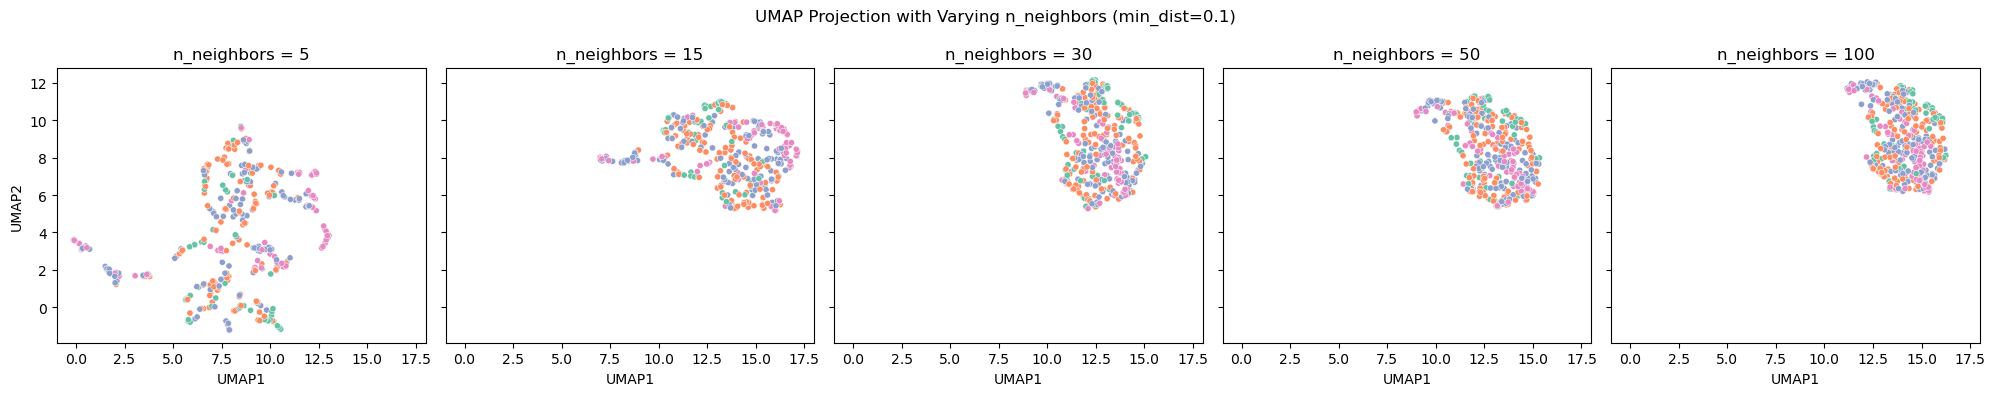

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans

# 1. Read data
df = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\2011_cleaned.csv")
# Only retain the data at the District level
df = df[df["County"].notnull() & df["District"].notnull()].copy()

# 2. Create the KMeans four-category label of health_index
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df["health_level_kmeans4"] = kmeans.fit_predict(df[["health_index"]])
centroids = kmeans.cluster_centers_.flatten()
ordered = sorted(range(len(centroids)), key=lambda x: centroids[x])
df["health_level_kmeans4"] = df["health_level_kmeans4"].map({old: f"Cluster {i+1}" for i, old in enumerate(ordered)})

# 3. Define the housing variable (X)
final_features = [
    "pct_detached", "pct_semi", "pct_terraced",
    "pct_flat_built", "pct_flat_converted", "pct_flat_commercial", "pct_mobile_home",
    "pct_heated", "pct_overcrowded_rooms", "pct_overcrowded_beds",
    "avg_rooms", "avg_bedrooms", "avg_household_size"
]
X = df[final_features]
y = df["health_level_kmeans4"]

# 4. standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. UMAP visualization under different n_neighbors
n_neighbors_list = [5, 15, 30, 50, 100]
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(20, 4), sharex=True, sharey=True)

for ax, n in zip(axes, n_neighbors_list):
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(X_scaled)
    df_temp = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
    df_temp["label"] = y.values
    sns.scatterplot(data=df_temp, x="UMAP1", y="UMAP2", hue="label", ax=ax, palette="Set2", s=20, legend=False)
    ax.set_title(f"n_neighbors = {n}")

plt.suptitle("UMAP Projection with Varying n_neighbors (min_dist=0.1)")
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\UMAP_with_Varying_n_neighbors.png')
plt.show()


D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n

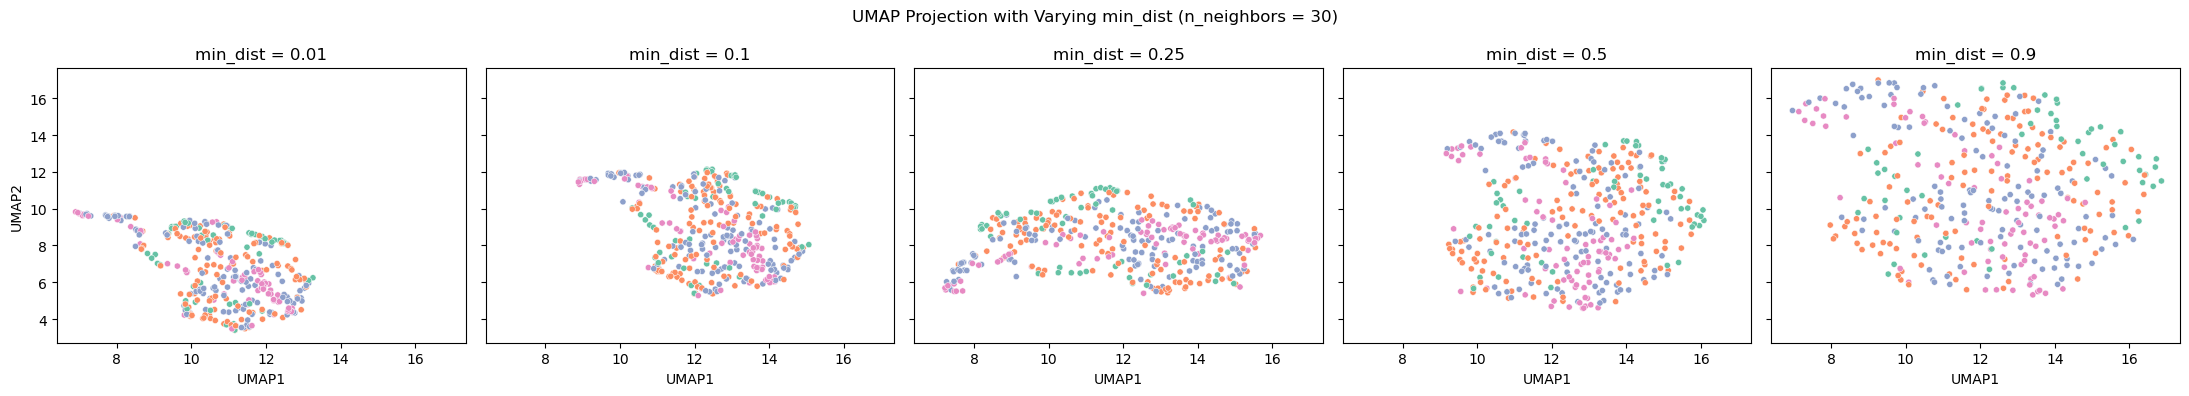

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans

# 1. Read data
df = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\2011_cleaned.csv")
# Only retain the data at the District level
df = df[df["County"].notnull() & df["District"].notnull()].copy()

# 2. Create the KMeans four-category label of health_index
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df["health_level_kmeans4"] = kmeans.fit_predict(df[["health_index"]])
centroids = kmeans.cluster_centers_.flatten()
ordered = sorted(range(len(centroids)), key=lambda x: centroids[x])
df["health_level_kmeans4"] = df["health_level_kmeans4"].map({old: f"Cluster {i+1}" for i, old in enumerate(ordered)})

# 3. Define the housing variable (X)
final_features = [
    "pct_detached", "pct_semi", "pct_terraced",
    "pct_flat_built", "pct_flat_converted", "pct_flat_commercial", "pct_mobile_home",
    "pct_heated", "pct_overcrowded_rooms", "pct_overcrowded_beds",
    "avg_rooms", "avg_bedrooms", "avg_household_size"
]
X = df[final_features]
y = df["health_level_kmeans4"]

# 4. standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. UMAP visualization under different min_dist
min_dist_list = [0.01, 0.1, 0.25, 0.5, 0.9]
fig, axes = plt.subplots(1, len(min_dist_list), figsize=(22, 4), sharex=True, sharey=True)

for ax, d in zip(axes, min_dist_list):
    reducer = umap.UMAP(n_neighbors=30, min_dist=d, n_components=2, random_state=42)
    embedding = reducer.fit_transform(X_scaled)
    df_temp = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
    df_temp["label"] = y.values
    sns.scatterplot(data=df_temp, x="UMAP1", y="UMAP2", hue="label", ax=ax, palette="Set2", s=20, legend=False)
    ax.set_title(f"min_dist = {d}")

plt.suptitle("UMAP Projection with Varying min_dist (n_neighbors = 30)")
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\UMAP_with_Varying_min_dist.png')
plt.show()


In [98]:
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Read data
df = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\2011_cleaned.csv")
# Only retain the data at the District level
df = df[df["County"].notnull() & df["District"].notnull()].copy()

# 2. Construct health_level_kmeans4 label
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df["health_level_kmeans4_raw"] = kmeans.fit_predict(df[["health_index"]])
centroids = kmeans.cluster_centers_.flatten()
ordered = sorted(range(len(centroids)), key=lambda x: centroids[x])
label_map = {old: f"Cluster {i+1}" for i, old in enumerate(ordered)}
df["health_level_kmeans4"] = df["health_level_kmeans4_raw"].map(label_map)

# 3. Select the housing variable as the input of UMAP
features = [
    "pct_detached", "pct_semi", "pct_terraced",
    "pct_flat_built", "pct_flat_converted", "pct_flat_commercial", "pct_mobile_home",
    "pct_heated", "pct_overcrowded_rooms", "pct_overcrowded_beds",
    "avg_rooms", "avg_bedrooms", "avg_household_size"
]
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Perform UMAP dimensionality reduction (optimal parameters)
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# 5. Perform UMAP dimensionality reduction (optimal parameters)
df_umap = df[["Area code", "health_level_kmeans4"]].copy()
df_umap["UMAP1"] = embedding[:, 0]
df_umap["UMAP2"] = embedding[:, 1]

# 6. Save results
df_umap.to_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\umap_projection_final.csv", index=False)
df_umap

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,Area code,health_level_kmeans4,UMAP1,UMAP2
11,E08000020,Cluster 1,13.632091,10.965263
12,E08000021,Cluster 2,11.987837,11.023072
13,E08000022,Cluster 2,13.805300,10.835842
14,E08000023,Cluster 1,13.710735,10.897324
15,E08000024,Cluster 1,13.827009,10.823512
...,...,...,...,...
390,W06000018,Cluster 1,13.625295,10.269393
391,W06000019,Cluster 1,13.086169,11.835077
392,W06000020,Cluster 1,13.116121,11.710924
393,W06000021,Cluster 2,13.525942,6.060469


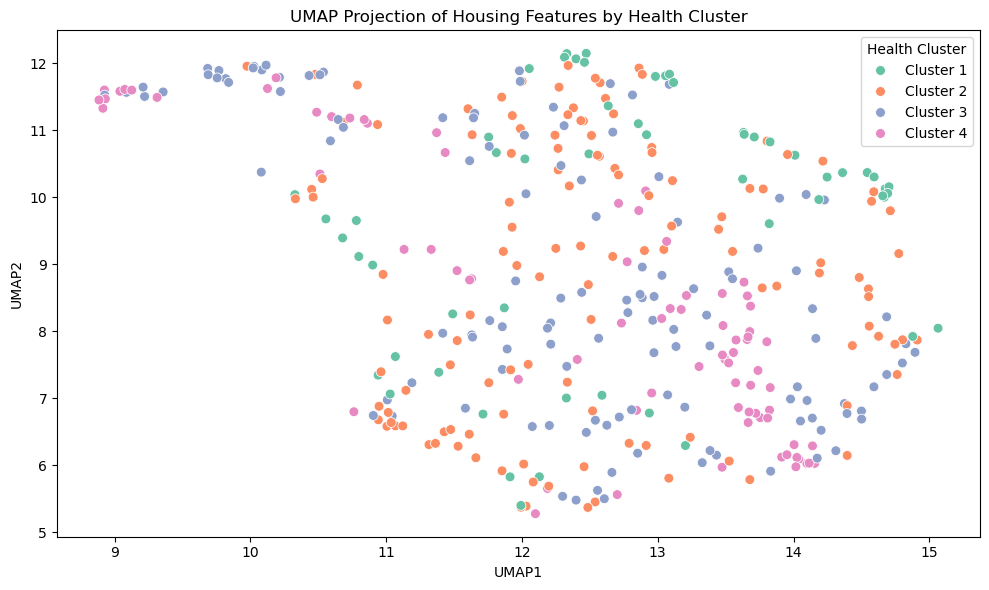

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv(r"D:\Users\lenovo\Desktop\VA_Data\Dimensionality_Reduction\umap_projection_final.csv")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="UMAP1",
    y="UMAP2",
    hue="health_level_kmeans4",
    palette="Set2",
    s=50
)
plt.title("UMAP Projection of Housing Features by Health Cluster")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Health Cluster")
plt.tight_layout()
plt.savefig(r'D:\Users\lenovo\Desktop\VA_Data\VA_Figures\UMAP_Optimal.png')
plt.show()
